In [1]:
import warnings
warnings.filterwarnings('ignore')

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob 
import aplpy
from tqdm.auto import tqdm
from astropy.utils.console import ProgressBar

import sys
sys.path.append('/Users/abarnes/GitHub/misc/data_cube_analysis/')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 


import getdata
import moments
import rms
import masks

In [2]:
inputdir = '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/'
inputfiles = glob.glob('%s/*.fits' %inputdir)
inputfiles = np.sort(inputfiles)
inputfiles.sort()
inputfiles

array(['/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_DCN_L10-merged.fits',
       '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_DCOp_L09-merged.fits',
       '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_DNC_L16-merged.fits',
       '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_HCN_L22-merged.fits',
       '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_HCOp_L25-merged.fits',
       '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_HNC_L27-merged.fits',
       '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_N2Dp_L18-merged.fits',
       '/Users/abarnes/Dropbox/work/Projects/NOEMA/data/CloudH/CloudH_N2Hp_L30-merged.fits'],
      dtype='<U82')

In [3]:
def makeplot(moms, msd, hdu_mapmask, inputfile, outputdir = './../figures/'):

    bbox = dict(facecolor='whitesmoke',  alpha=0.95, boxstyle='round')
    
    fig = plt.figure(figsize=(7, 4))
    ax = aplpy.FITSFigure(moms['max'], figure=fig, subplot=(1,2,1))
    ax2 = aplpy.FITSFigure(msd, figure=fig, subplot=(1,2,2))

    vmin, vmax = np.nanpercentile(moms['max'].data, (0.5, 99.5))
    ax.show_colorscale(vmin=vmin, vmax=vmax, cmap='inferno')
    ax2.show_colorscale(vmin=0, vmax=0.3, cmap='turbo')

    for ax_ in [ax, ax2]:

        ax_.axis_labels.hide()
        ax_.tick_labels.hide()

        ax_.add_colorbar()
        ax_.ticks.set_color('black')
        ax_.colorbar.set_width(0.15)

        levels = np.nanmax(moms['max'].data)*np.linspace(0.25,0.99,6)
        max_tmp = moms['max'].copy()
        max_tmp.data[np.isnan(max_tmp.data)] = 0
        ax_.show_contour(max_tmp, levels=levels, colors='black', linewidths=0.5, smooth=1)
        # ax_.show_contour(moms['maxs2n'], levels=[3,5,10,15,20,25,50], colors='black', linewidths=0.5, smooth=1)
        ax_.show_contour(hdu_mapmask, levels=[1], colors='black', linewidths=0.5, linestyles='--')
        ax_.set_nan_color('lightgrey')
        ax_.recenter(284.2821892, 2.1782806, 0.0413832, 0.0689720)

    label = inputfile.split('/')[-1].split('.')[0].replace('CloudH_', '')
    label = label.split('_')[0]
    ax.add_label(0.05, 0.95, label,  ha='left', va='top', size=10, bbox = bbox, relative=True)

    # ax_plot = fig.get_axes()[-1]
    # ax_plot.grid(True, alpha=0.35, ls=':', color='white')

    ax.colorbar.set_axis_label_text('T (max) [K]')
    ax2.colorbar.set_axis_label_text('Mass Surface Density [g/cm2]')

    ax.colorbar.set_location('top')
    ax2.colorbar.set_location('top')

    axes = fig.get_axes()
    for ax_ in axes: 
        ax_.set_facecolor('lightgrey')
        ax_.grid(True, alpha=0.35, ls=':', color='white')

    fig.tight_layout(h_pad=0, w_pad=0.3)

    outputfile = outputdir+inputfile.split('/')[-1].replace('.fits', '.png')
    fig.savefig(outputfile, bbox_inches='tight', dpi=300)  

    outputfile = outputdir+inputfile.split('/')[-1].replace('.fits', '.pdf')
    fig.savefig(outputfile, bbox_inches='tight', dpi=300)  
    plt.close('all')
    
    return()

In [4]:
inputfiles = [inputfiles[3]]

In [10]:
mom_velocitydict = {'cloudH': np.array([35, 55])}
rms_velocitydict = {'cloudH': np.array([[-200, 30], [60, 200]])}

hdu_msd = fits.open('/Users/abarnes/Dropbox/work/Projects/KT_extinction_maps/new/data/cloudH.msd.fits')[0]

for inputfile in tqdm(inputfiles):

    cloud = inputfile.split('/')[-1].split('_')[0]
    hdu = fits.open(inputfile)[0]
    cube = getdata.get_cube(hdu)
    rms_map = rms.get_rmsrob(cube)
    hdu_mapmask = fits.PrimaryHDU(~np.isnan(rms_map.data)*1, rms_map.header)

    mask = masks.get_expmask(cube, rms_map, hthresh=3, lthresh=2, beamarea=1, npix=3)
    cube_masked = cube.with_mask(mask)
    velo = np.array([-200,150])

    moms = moments.get_momentmaps(cube_masked, rms_map, mom_velocitydict['cloudH'], velomoms=True)
    # makeplot(moms, hdu_msd, hdu_mapmask, inputfile)

    # outputfile = inputfile.replace(inputdir, './../mom_28').replace('.fits', '')
    # rms_map.writeto('%s_rms.fits' %outputfile, overwrite=True)
    # moms['mom0'].writeto('%s_mom.fits' %outputfile, overwrite=True)
    # moms['max'].writeto('%s_max.fits' %outputfile, overwrite=True)
    # moms['mom0s2n'].writeto('%s_mom0s2n.fits' %outputfile, overwrite=True)

  0%|          | 0/1 [00:00<?, ?it/s]

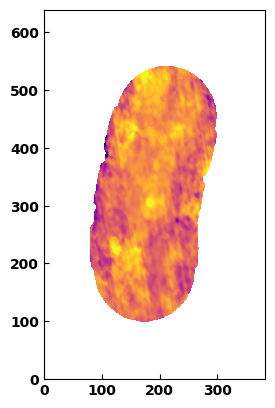

In [23]:
plt.imshow(moms['sigma'].data, origin='lower', cmap='plasma', vmin=3, vmax=5)